In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm, metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, GroupKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_error, roc_auc_score, precision_score, make_scorer, accuracy_score
from sklearn.linear_model import LassoCV, Lasso, LassoLarsIC, ElasticNet, LassoLarsCV
from sklearn.externals import joblib
from scipy.stats import randint as sp_randint
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import biom
import calour as ca
from scipy import stats
import scipy
import pickle
import time
import math
pd.set_option('display.max_rows', 10000)

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Importing data, no TSS normalization performed here

In [3]:
allMetab = ca.read_amplicon('PMI_MS1_FeatureTable_Normalized.biom','pmi3_metab_meta.txt', min_reads=1, normalize = None)

## Remove controls and samples that grouped with controls on PCoA

In [4]:
allMetab = allMetab.filter_samples('control', 'n')
allMetab = allMetab.filter_samples('pcoa_removals', 'n')
allMetab.sample_metadata.description.value_counts()

skin.hip    746
soil.hip    744
Name: description, dtype: int64

## Seperate general model validation bodies and training bodies

In [5]:
allMetab_train = allMetab.filter_samples('validation_set', 'n')
allMetab_val = allMetab.filter_samples('validation_set', 'y')

In [6]:
allMetab_train.sample_metadata.description.value_counts()

skin.hip    497
soil.hip    493
Name: description, dtype: int64

In [7]:
allMetab_val.sample_metadata.description.value_counts()

soil.hip    251
skin.hip    249
Name: description, dtype: int64

In [8]:
#allMetab.sample_metadata.columns

In [9]:
#dir(allMetab)

In [10]:
#print(allMetab.feature_metadata)

# Split by sampling location (soil v. skin)

## Skin sample filtering

In [11]:
allMetab_skin = allMetab.filter_samples('sample_type', 'skin')
allMetab_skin.sample_metadata.sample_type.value_counts()

skin    746
Name: sample_type, dtype: int64

In [12]:
Metab_train_skin = allMetab_train.filter_samples('sample_type', 'skin')
Metab_train_skin.sample_metadata.sample_type.value_counts()

skin    497
Name: sample_type, dtype: int64

In [13]:
Metab_val_skin = allMetab_val.filter_samples('sample_type', 'skin')
Metab_val_skin.sample_metadata.sample_type.value_counts()

skin    249
Name: sample_type, dtype: int64

# Skin General Model of Facilities and Season using ADD 0C as Response and Adding Metadata

In [14]:
Metab_train_skin_meta = Metab_train_skin.add_sample_metadata_as_features(['season','facility','avg_percent_humidity','total_precipitation_cm'])

#print(Metab_train_skin_meta.feature_metadata)

In [21]:
gkf = GroupKFold(6)

X_train = Metab_train_skin_meta.data
y_train = Metab_train_skin_meta.sample_metadata['add_0c']
y_train = (y_train.astype(float))
groups = Metab_train_skin_meta.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [None],
          "max_features": [0.1],
          "min_samples_split": [0.001],
          "min_weight_fraction_leaf": [0.01],
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=10, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_train, y_train, groups), scoring='r2', n_jobs=1)

In [22]:
gs.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x125a52c50>,
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mae', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=999,
                                             verbo

In [23]:
print(gs.best_params_)

{'bootstrap': False, 'max_depth': None, 'max_features': 0.1, 'min_samples_split': 0.001, 'min_weight_fraction_leaf': 0.01}


In [24]:
print('The best mean error rate is', round(-gs.best_score_,2))

#with open('skin_model_errors.txt', 'a') as out:
#    out.write('model\tmae\tr2_score\n')
#    out.write('general_skin_train_meta\t'+str(round(-gs.best_score_,2))+'\n')

#out.close

The best mean error rate is -0.48


In [17]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_skin_meta_general.pkl')

['models/PMI3_Metab_skin_meta_general.pkl']

In [15]:
model_Metab_skin_meta = joblib.load('models/PMI3_Metab_skin_meta_general.pkl')

In [16]:
model_Metab_skin_meta

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [18]:
rfecv = RFECV(estimator=model_Metab_skin_meta, step=0.05, cv=list(gkf.split(X_train, y_train, groups)), scoring='neg_mean_absolute_error', n_jobs=1)

In [21]:
# Likely need to run on Summit
rfecv.fit(X_train, y_train)

RFECV(cv=[(array([  0,   1, ..., 494, 495]), array([ 46,  47, ..., 486, 496])), (array([  0,   1, ..., 495, 496]), array([ 39,  40, ..., 481, 482])), (array([  0,   1, ..., 495, 496]), array([ 92,  93, ..., 451, 490])), (array([  3,   4, ..., 495, 496]), array([  0,   1, ..., 476, 487])), (array([  0,   1, ..., 495, 496]), array([  3,   4, ..., 488, 489])), (array([  0,   1, ..., 490, 496]), array([106, 107, ..., 494, 495]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [22]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 22
Optimal number of features : 669
The best mean absolute error is: 69


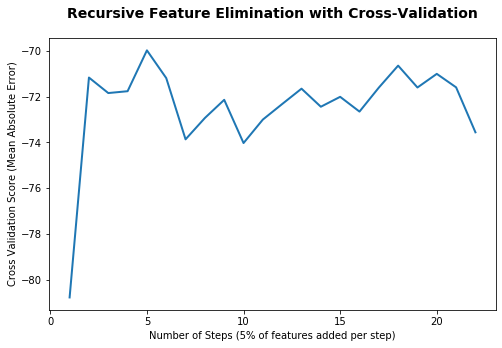

In [23]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/general_skin_model_meta_rfecv.png')

In [ ]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_skin_meta_general_rfecv.pkl')

In [19]:
model_Metab_skin_meta_rfecv = joblib.load('models/PMI3_Metab_skin_meta_general_rfecv.pkl')
model_Metab_skin_meta_rfecv

AttributeError: 'RFECV' object has no attribute 'estimator_'

### Predicting training data (will be overfit but good sanity check)

In [20]:
# Removes the unimportant features from X
X_train = rfecv.transform(X_train)

yhat = model_Metab_skin_meta_rfecv.predict(X_train)
MAE = mean_absolute_error(y_train, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')

#Score of best estimator when used to estimate training data (will be overfit)
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_skin_meta_rfecv.score(X_train,y_train),2))

NotFittedError: This RFECV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

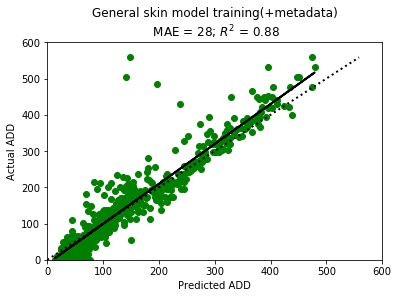

In [27]:
plt.scatter(yhat, y_train, color = 'g')
lower = np.min(np.concatenate([y_train, yhat]))
upper = np.max(np.concatenate([y_train, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_train)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General skin model training(+metadata)\n MAE = %d; $R^2$ = %.2f' %(MAE,round(model_Metab_skin_meta_rfecv.score(X_train,y_train),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_skin_model_training_meta_rfecv.png')

### Determine important features after RFECV

In [29]:
importances = model_Metab_skin_meta_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_skin_meta_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_train_skin_meta.feature_metadata
np.savetxt("feature_metadata/general_skin_feature_metadata_meta_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
skin_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    skin_importances += (Metab_train_skin_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_train_skin_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X411.341111879091_6.43193198198198	0.15357118973078682
2. X169.083052596884_3.02616638477801	0.08661811794560667
3. X565.517636027714_7.72472345775013	0.0480321373769807
4. X546.397528446081_6.44098922558922	0.04641891475565942
5. X270.278053283691_7.43078325242718	0.03505608419299071
6. X287.149186666032_2.44809351032448	0.03353002668135285
7. X365.135131404085_0.799185324947588	0.03278005688454212
8. X279.230757406719_6.39681497927768	0.03181816600854706
9. X323.163880547811_3.47024656007752	0.02050757866678695
10. X362.19378153483_3.07285879629629	0.014713249060311896
11. X289.167932739257_2.79415266666666	0.011070566757495268
12. X401.338991000014_8.13704111956867	0.01024792955091484
13. X665.470313750117_6.80325582329316	0.00938362620302085
14. X701.392317345394_3.07152462311557	0.009020890776091615
15. X256.262006528934_7.07576439121756	0.008823533575236362
16. X305.135615437175_3.40880985090521	0.00879807615018877
17. X195.098852603876_3.7230375449964	

In [30]:
# make sure shape is right
print("Number of features present:", int(len(skin_importances)/2))
skin_importances_df = pd.DataFrame(np.array(skin_importances).reshape(int(len(skin_importances)/2),2))

np.savetxt("importances/general_skin_importances_meta_rfecv.csv", skin_importances_df, delimiter=",", fmt='%s')

Number of features present: 669


## Testing on validaiton set

In [ ]:
Metab_val_skin_meta = Metab_val_skin.add_sample_metadata_as_features(['season','facility','avg_percent_humidity','total_precipitation_cm'])

In [31]:
X_val = rfecv.transform(Metab_val_skin_meta.data) #removing the unimportant features from X as determined by RFECV
y_val = Metab_val_skin_meta.sample_metadata['add_0c']
y_val = (y_val.astype(float))

yhat = model_Metab_skin_meta_rfecv.predict(X_val)

# cross-model error (cross-experiment error)
MAE = mean_absolute_error(y_val, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_skin_meta_rfecv.score(X_val,y_val),2))

with open('skin_model_errors.txt', 'a') as out:
   out.write('general_skin_train_pred_val_meta_rfecv\t'+str(round(MAE, 2))+'\t'+str(round(model_Metab_skin_meta_rfecv.score(X_val,y_val),2))+'\n')
out.close

Mean Absolute Error: 59.58 ADD
Coefficient of determination R^2 of the prediction: 0.67


/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


<function TextIOWrapper.close()>

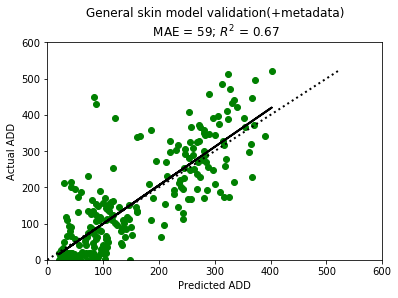

In [32]:
plt.scatter(yhat, y_val, color = 'g')
lower = np.min(np.concatenate([y_val, yhat]))
upper = np.max(np.concatenate([y_val, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_val)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General skin model validation(+metadata)\n MAE = %d; $R^2$ = %.2f' %(MAE,round(model_Metab_skin_meta_rfecv.score(X_val,y_val),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_skin_model_validation_meta_rfecv.png')

# Skin General Model of Facilities and Season using ADD 0C as Response without Metadata

In [33]:
gkf = GroupKFold(6)

X_train = Metab_train_skin.data
y_train = Metab_train_skin.sample_metadata['add_0c']
y_train = (y_train.astype(float))
groups = Metab_train_skin.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
#
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [8],
          "max_features": [0.1],
          "min_samples_split": [0.001],
          "min_weight_fraction_leaf": [0.01],
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=10, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_train, y_train, groups), scoring='neg_mean_absolute_error', n_jobs=1)

In [34]:
gs.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x11bd9fed0>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8], 'max_features': [0.1], 'min_samples_split': [0.001], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.01], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(gs.best_params_)

In [35]:
print('The best mean error rate is', round(-gs.best_score_,2))

with open('skin_model_errors.txt', 'a') as out:
    out.write('model\tmae\tr2_score\n')
    out.write('general_skin_train\t'+str(round(-gs.best_score_,2))+'\n')

out.close

The best mean error rate is 71.06


<function TextIOWrapper.close()>

In [36]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_skin_general.pkl')

['models/PMI3_Metab_skin_general.pkl']

In [16]:
model_Metab_skin = joblib.load('models/PMI3_Metab_skin_general.pkl')

In [17]:
model_Metab_skin

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [39]:
rfecv = RFECV(estimator=model_Metab_skin, step=0.05, cv=list(gkf.split(X_train, y_train, groups)), scoring='neg_mean_absolute_error', n_jobs=1)

In [40]:
# Likely need to run on Summit
rfecv.fit(X_train, y_train)

RFECV(cv=[(array([  0,   1, ..., 494, 495]), array([ 46,  47, ..., 486, 496])), (array([  0,   1, ..., 495, 496]), array([ 39,  40, ..., 481, 482])), (array([  0,   1, ..., 495, 496]), array([ 92,  93, ..., 451, 490])), (array([  3,   4, ..., 495, 496]), array([  0,   1, ..., 476, 487])), (array([  0,   1, ..., 495, 496]), array([  3,   4, ..., 488, 489])), (array([  0,   1, ..., 490, 496]), array([106, 107, ..., 494, 495]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [41]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 21
Optimal number of features : 2420
The best mean absolute error is: 69


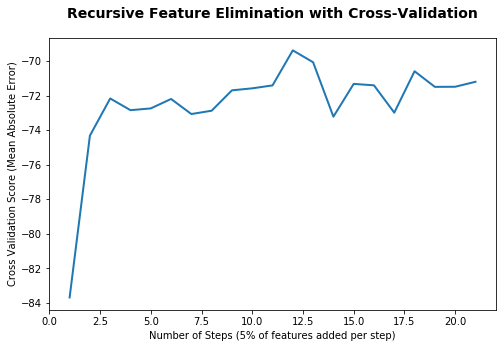

In [42]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/general_skin_model_rfecv.png')

In [ ]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_skin_general_rfecv.pkl')

In [43]:
model_Metab_skin_rfecv = joblib.load('models/PMI3_Metab_skin_general_rfecv.pkl')
model_Metab_skin_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Predicting training data (will be overfit but good sanity check)

In [44]:
# Removes the unimportant features from X
X_train = rfecv.transform(X_train)

yhat = model_Metab_skin_rfecv.predict(X_train)
MAE = mean_absolute_error(y_train, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')

#Score of best estimator when used to estimate training data (will be overfit)
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_skin_rfecv.score(X_train,y_train),2))

Mean Absolute Error: 29.63 ADD
Coefficient of determination R^2 of the prediction: 0.87


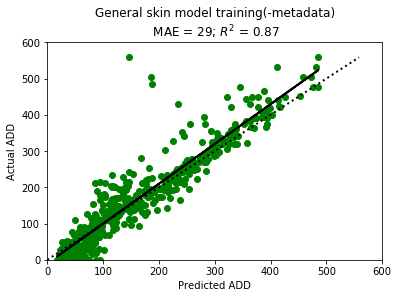

In [45]:
plt.scatter(yhat, y_train, color = 'g')
lower = np.min(np.concatenate([y_train, yhat]))
upper = np.max(np.concatenate([y_train, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_train)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General skin model training(-metadata)\n MAE = %d; $R^2$ = %.2f' %(MAE,round(model_Metab_skin_rfecv.score(X_train,y_train),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_skin_model_training_rfecv.png')

### Determine important features after RFECV

In [46]:
importances = model_Metab_skin_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_skin_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_train_skin.feature_metadata
np.savetxt("feature_metadata/general_skin_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
skin_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    skin_importances += (Metab_train_skin.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_train_skin.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X230.170335788919_2.66187542087542	0.06646604739772158
2. X200.200297817107_5.5910755376344	0.05930083182410182
3. X215.156754455566_3.90129799999999	0.05475230978212142
4. X187.132559969724_3.54547162954278	0.05275073705085649
5. X155.106733620572_5.7184044217687	0.049175345018563146
6. X398.360675666905_7.01279367088607	0.03608012700873922
7. X258.205304505395_3.60571584699453	0.036055744660642416
8. X272.220237223307_3.983025	0.03566691314728617
9. X225.110203975695_3.87167830940988	0.03283642557347406
10. X201.111491762358_3.33599339080459	0.029800468587155134
11. X278.189859650704_4.10320385434824	0.022635919894267838
12. X596.435729980468_5.41112721088435	0.01595085306225511
13. X336.235949751259_6.00681352657004	0.014668372884556871
14. X511.251072276722_3.17356939393939	0.01323537159835166
15. X215.131461096591_5.04396530054644	0.011746176250117124
16. X279.230997695859_5.90311805903647	0.011679705783370896
17. X669.93791489374_6.24358174603174	0.0099

In [47]:
# make sure shape is right
print("Number of features present:", int(len(skin_importances)/2))
skin_importances_df = pd.DataFrame(np.array(skin_importances).reshape(int(len(skin_importances)/2),2))

np.savetxt("importances/general_skin_importances_rfecv.csv", skin_importances_df, delimiter=",", fmt='%s')

Number of features present: 2420


## Testing on validaiton set

In [50]:
X_val = rfecv.transform(Metab_val_skin.data) #removing the unimportant features from X as determined by RFECV
y_val = Metab_val_skin.sample_metadata['add_0c']
y_val = (y_val.astype(float))

yhat = model_Metab_skin_rfecv.predict(X_val)

# cross-model error (cross-experiment error)
MAE = mean_absolute_error(y_val, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_skin_rfecv.score(X_val,y_val),2))

with open('skin_model_errors.txt', 'a') as out:
   out.write('general_skin_train_pred_val_rfecv\t'+str(round(MAE, 2))+'\t'+str(round(model_Metab_skin_rfecv.score(X_val,y_val),2))+'\n')
out.close

Mean Absolute Error: 57.06 ADD
Coefficient of determination R^2 of the prediction: 0.69


<function TextIOWrapper.close()>

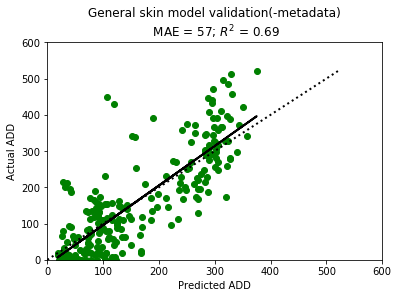

In [51]:
plt.scatter(yhat, y_val, color = 'g')
lower = np.min(np.concatenate([y_val, yhat]))
upper = np.max(np.concatenate([y_val, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_val)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General skin model validation(-metadata)\n MAE = %d; $R^2$ = %.2f' %(MAE,round(model_Metab_skin_rfecv.score(X_val,y_val),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_skin_model_validation.png')